In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

# **IMPORT DATA**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Getting names of the classes we have
data_directory = pathlib.Path('/content/drive/MyDrive/DEEP LEARNING/test')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(class_names)

['not_pizza', 'pizza']


In [ ]:
pizza_dir = '/content/drive/MyDrive/DEEP LEARNING/train/pizza'
not_pizza_dir = '/content/drive/MyDrive/DEEP LEARNING/train/not_pizza'
data_dir = '/content/drive/MyDrive/DEEP LEARNING/train'

In [ ]:
pizza_dir

'/content/drive/MyDrive/DEEP LEARNING/train/pizza'

In [ ]:
num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 800
Number of Non-Pizza images: 800


In [ ]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [ ]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [ ]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """

    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 5))

    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()
    plt.show()

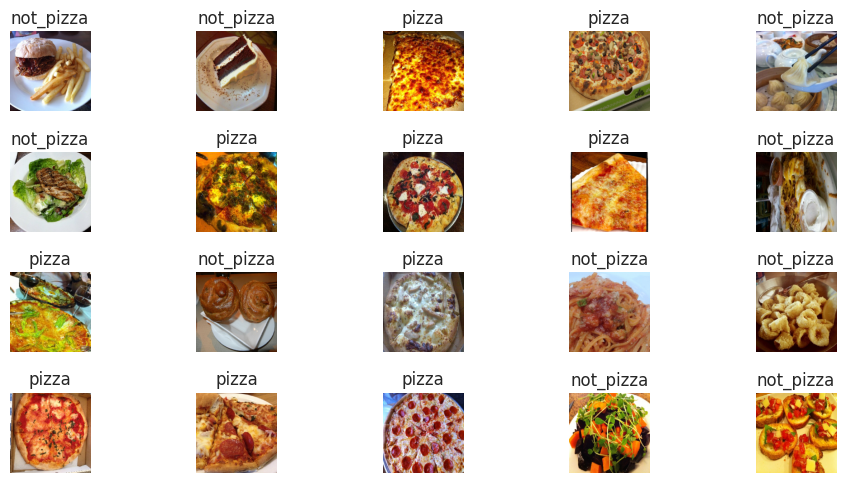

In [ ]:
plot_random_images()

# **BASELINE MODEL**

In [ ]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(2,2), # First Convolutional layer
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(2,2),# Second Convolutional layer
    Conv2D(filters = 128, kernel_size= 2, padding = 'valid', activation = 'relu'), MaxPool2D(2,2),# Third Convolutional layer
    Dropout(0.2),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01,l2=0.01)) # Output layer
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 9s 169ms/step - loss: 0.9829 - accuracy: 0.5063 - val_loss: 0.7962 - val_accuracy: 0.6531
Epoch 2/5
40/40 [==============================] - 8s 195ms/step - loss: 0.7581 - accuracy: 0.6117 - val_loss: 0.7962 - val_accuracy: 0.5406
Epoch 3/5
40/40 [==============================] - 7s 170ms/step - loss: 0.7087 - accuracy: 0.6531 - val_loss: 0.6801 - val_accuracy: 0.6812
Epoch 4/5
40/40 [==============================] - 8s 192ms/step - loss: 0.6454 - accuracy: 0.7188 - val_loss: 0.7081 - val_accuracy: 0.6094
Epoch 5/5
40/40 [==============================] - 7s 168ms/step - loss: 0.5824 - accuracy: 0.7555 - val_loss: 0.6065 - val_accuracy: 0.7375


# **VISUALISASI HASIL**

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

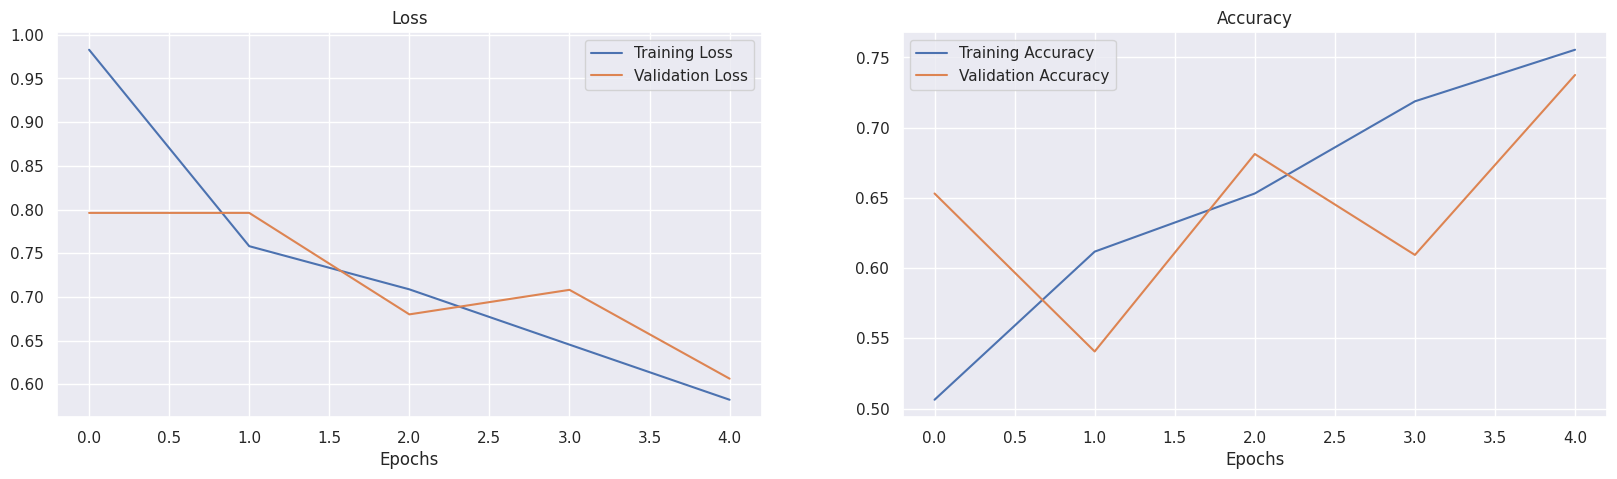

In [ ]:
plot_loss_curves(history_1)

**Menambahkan Max Pooling Layer dan Data Augmentasi**

In [ ]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data, # Using non-augmented data
                        epochs= 10,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/10
40/40 [==============================] - 9s 182ms/step - loss: 0.6759 - accuracy: 0.5500 - val_loss: 0.6576 - val_accuracy: 0.6281
Epoch 2/10
40/40 [==============================] - 7s 165ms/step - loss: 0.6217 - accuracy: 0.6852 - val_loss: 0.6219 - val_accuracy: 0.6531
Epoch 3/10
40/40 [==============================] - 7s 184ms/step - loss: 0.5920 - accuracy: 0.6797 - val_loss: 0.6032 - val_accuracy: 0.6750
Epoch 4/10
40/40 [==============================] - 6s 158ms/step - loss: 0.5640 - accuracy: 0.7133 - val_loss: 0.5893 - val_accuracy: 0.6562
Epoch 5/10
40/40 [==============================] - 7s 180ms/step - loss: 0.5516 - accuracy: 0.7266 - val_loss: 0.5765 - val_accuracy: 0.6687
Epoch 6/10
40/40 [==============================] - 6s 162ms/step - loss: 0.5335 - accuracy: 0.7391 - val_loss: 0.5620 - val_accuracy: 0.6906
Epoch 7/10
40/40 [==============================] - 6s 161ms/step - loss: 0.5109 - accuracy: 0.7602 - val_loss: 0.5456 - val_accuracy: 0.7219
Epoch 

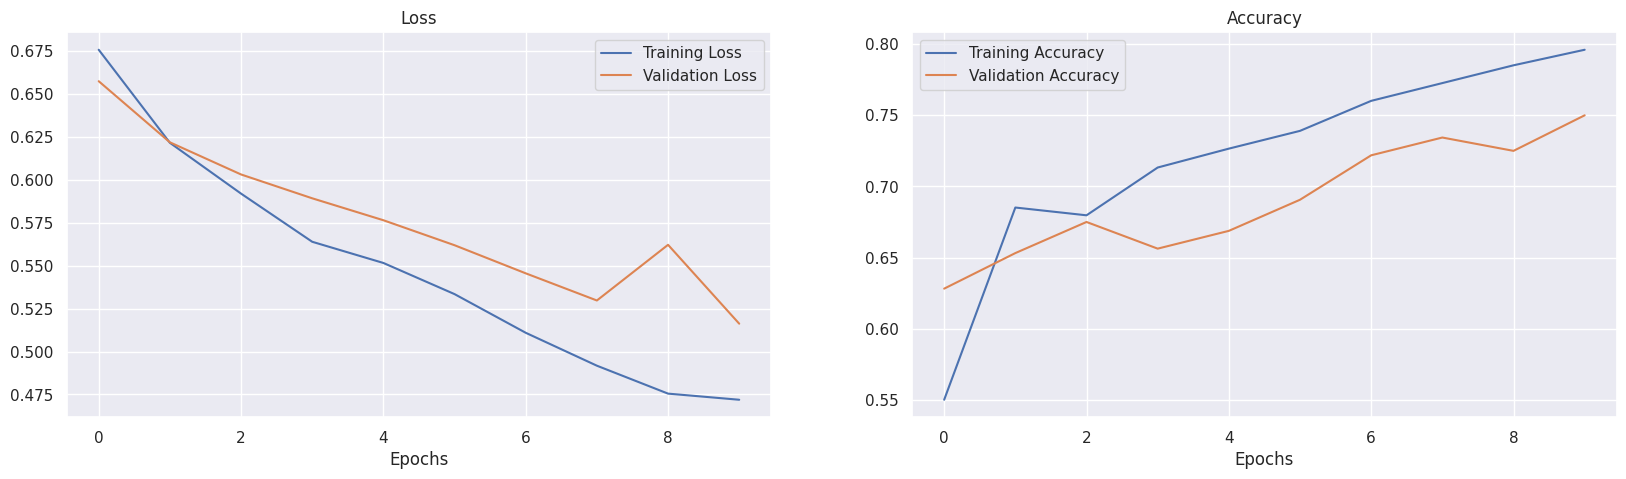

In [ ]:
plot_loss_curves(history_2)

**TRANSFER LEARNING**

In [ ]:
# EfficientNetB7 feature vector
url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'

feature_extractor_layer = hub.KerasLayer(url,
                                         trainable=False,
                                         input_shape=(224, 224, 3))

model_3 = Sequential([
    feature_extractor_layer,
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_3 = model_3.fit(train_data,
                        epochs= 1,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

40/40 [==============================] - 34s 535ms/step - loss: 0.3051 - accuracy: 0.9023 - val_loss: 0.1582 - val_accuracy: 0.9531


In [ ]:
test_loss, test_acc = model_3.evaluate(val_data)

print(f"test accuracy : {round(test_acc * 100)}%")

10/10 [==============================] - 3s 326ms/step - loss: 0.1582 - accuracy: 0.9531
test accuracy : 95%
